<a href="https://colab.research.google.com/github/snu-digital-finance/ProductionML/blob/main/Flow_of_Latent_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

layer initialization seed setting

https://keras.io/api/layers/core_layers/dense/
- kernel_initializer="glorot_uniform",
- bias_initializer="zeros",


Additional Seed setting for weight initialization!!

- kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED)


Summary of Seed Setting
1. original model: seed=42 for all layers
2. Transfer Learning : seed=84 for adjustable layers

3. 10 trials mean:
- Original model: seed=random for all layer
- Transfer learning:  seed=random for adjustable layers

## Terminology

In [1]:
from dataclasses import dataclass
@dataclass
class Notation:
    y1: str = "K-Int."
    y2: str = "K-Light"
    y3: str = "L-Int."

note = Notation()

## Visualization

In [2]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from itertools import count
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Lambda


# === 1. Data ===
SEED=42
np.random.seed(SEED)
tf.random.set_seed(SEED)
rng = np.random.default_rng(SEED)

Fixed_Dense = lambda n, activation: Dense(
    n, activation = activation,
    kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
)


In [3]:
FIG_NO = count(1)

def _expand_title(title_prefix: str) -> str:
    """
    Parse tokens like "<TL K^3 + y2 → y2>" or "[TL y1 + y2 → y2]" and
    convert to a readable figure title, e.g., "y1 transfer learned with y2"
    (if target == finetune) or "y1 transfer learned with y2 to predict y3".
    Falls back to the raw prefix (with brackets removed) if parsing fails.
    """
    # extract inside <> or []
    m = re.search(r'[\[<]\s*(.*?)\s*[\]>]', title_prefix or "")
    core = (m.group(1) if m else title_prefix or "").strip()

    # try to parse "TL A + B → T"
    m2 = re.match(r'^TL\s+(.+?)\s*\+\s*(.+?)\s*→\s*(.+)$', core)
    if not m2: # remove brackets and return
      return core
    A, B, T = [s.strip() for s in m2.groups()]
    return f"{A} transfer learned with {B}" + " to predict {T}" if T != B else ""


def draw_triptych(title_prefix, Kv, Lv, y_true, y_pred,
                  fig_no=None, caption=None, y_lim=None, show=True):
    if fig_no is None:
        fig_no = next(FIG_NO)

    mse = (y_true - y_pred) ** 2
    cmap_y = "Greys"
    m_true, m_pred = "o", "^"
    edge = "black"

    fig = plt.figure(figsize=(10, 4))
    gs = GridSpec(nrows=1, ncols=3, figure=fig, width_ratios=[1, 1, 1])

    # (a) True — 3D
    ax1 = fig.add_subplot(gs[0, 0], projection='3d')
    ax1.scatter(Kv, Lv, y_true, c=y_true, cmap=cmap_y,
                alpha=0.8, s=14, marker=m_true, edgecolor=edge, linewidth=0.3)
    ax1.set_title("(a) True Y")
    ax1.set_xlabel("K"); ax1.set_ylabel("L"); ax1.set_zlabel("Y")
    ax1.set_xlim(0, 1); ax1.set_ylim(0, 1)
    if y_lim is not None:
        ax1.set_zlim(*y_lim)

    # (b) Predicted — 3D
    ax2 = fig.add_subplot(gs[0, 1], projection='3d')
    ax2.scatter(Kv, Lv, y_pred, c=y_pred, cmap=cmap_y,
                alpha=0.8, s=14, marker=m_pred, edgecolor=edge, linewidth=0.3)
    ax2.set_title("(b) Predicted Ŷ")
    ax2.set_xlabel("K"); ax2.set_ylabel("L"); ax2.set_zlabel("Ŷ")
    ax2.set_xlim(0, 1); ax2.set_ylim(0, 1)
    if y_lim is not None:
        ax2.set_zlim(*y_lim)

    # (c) MSE — 2D: x = varying axis (K or L), y = MSE
    ax3 = fig.add_subplot(gs[0, 2])
    if np.nanstd(Lv) < 1e-9:
        x_vals, x_label = np.ravel(Kv), "K"
    elif np.nanstd(Kv) < 1e-9:
        x_vals, x_label = np.ravel(Lv), "L"
    else:
        x_vals, x_label = np.ravel(Kv), "K"
    ax3.scatter(x_vals, np.ravel(mse), c="dimgray", s=12,
                marker="s", edgecolor=edge, linewidth=0.3)
    ax3.set_title("(c) MSE (Y−Ŷ)^2\n")
    ax3.set_xlabel(x_label); ax3.set_ylabel("\n\n\n\nMSE")
    ax3.set_xlim(0, 1); ax3.set_ylim(0, 1)

    # Figure title from expanded prefix
    pretty = _expand_title(title_prefix)
    cap = f"Figure {fig_no}. {pretty}"
    if caption:
        cap += f" — {caption}"
    fig.suptitle(cap, fontsize=18, y=0.9)

    fig.subplots_adjust(left=0.05, right=0.98, top=0.9, bottom=0.05, wspace=0.35)
    ax1.text2D(0.02, 0.92, "○ True,  △ Pred,  ■ MSE",
               transform=ax1.transAxes, fontsize=9)

    if show:
      plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
      plt.show()


## Data Generation

In [4]:

n = 1000
noise_scale = 0.05

# K-intensive: K~U(0,1), L=0
K = np.random.rand(n, 1)
L0 = np.zeros((n, 1))
X_K = np.hstack([K, L0])

# L-intensive: K=0, L~U(0,1)
K0 = np.zeros((n, 1))
L = np.random.rand(n, 1)
X_L = np.hstack([K0, L])

# Targets with noise
y1 = K**3 + np.random.normal(0, noise_scale, size=(n, 1))      # K³ + noise
y2 = -K**3 + np.random.normal(0, noise_scale, size=(n, 1))     # −K³ + noise
y3 = L**3 + np.random.normal(0, noise_scale, size=(n, 1))      # L³ + noise
y4 = -L**3 + np.random.normal(0, noise_scale, size=(n, 1))


## Build & Train Model

### Build Original Model

In [5]:


# Original Model - 5 layers trained on y1
def build_model(fixed=True):
    d = Fixed_Dense if fixed else Dense
    m = Sequential([
        tf.keras.Input(shape=(2,)),
        Lambda(tf.nn.relu, name="input_relu"),
        d(64, activation="relu"),
        d(16, activation="relu"),
        d(4, activation="relu"),
        d(1, activation="linear")
    ])
    m.compile(optimizer="adam", loss="mse")
    return m

model = build_model()
model.fit(X_K, y1, epochs=100, batch_size=32, verbose=0)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_relu (Lambda)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,917 (15.30 KB)

 Trainable params: 1,305 (5.10 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,612 (10.21 KB)

In [6]:
from sklearn.metrics import mean_squared_error

def run_prediction(m_y2, m_y3, title, fig_no=1, caption=['', '', ''], isTL=False):
    global FIG_NO
    y2_pred = m_y2.predict(X_K, verbose=0)
    y3_pred = m_y3.predict(X_L, verbose=0)
    FIG_NO = count(fig_no)
    t = f'{title}\n{note.y1} '
    if isTL:
      t += '+ '
      draw_triptych(f"{t}{note.y2} → {note.y2}{': '+caption[0]}", K, L0,  y2, y2_pred, y_lim = (-1,0))
      draw_triptych(f"{t}{note.y2} → Negative {note.y2}{': '+caption[1]}", K, L0,  y1, -y2_pred, y_lim = (-1,0))
      draw_triptych(f"{t}{note.y3} → {note.y3}{': '+caption[2]}", K0, L, y3, y3_pred, y_lim = (0,1))
    else:
      draw_triptych(f"{t}→ {note.y1}", K, L0, y1, y2_pred)
      draw_triptych(f"{t}→ {note.y2}", K, L0, y2, y2_pred)
      draw_triptych(f"{t}→ {note.y3}", K0, L, y3, y3_pred, y_lim=(0, 1))

# Run

## Original Model Evaluated on untrained data - high MSE

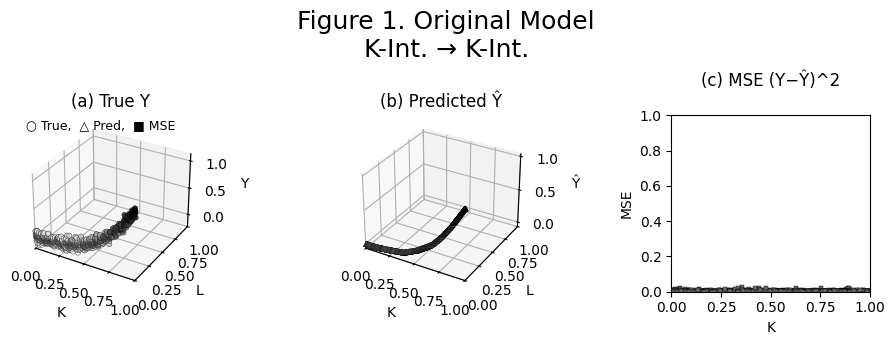

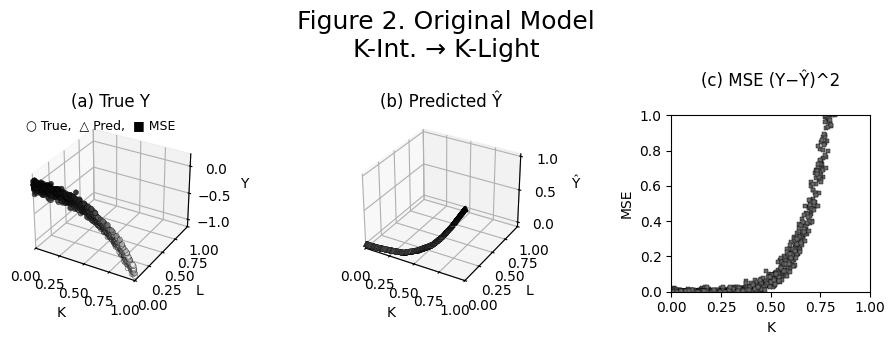

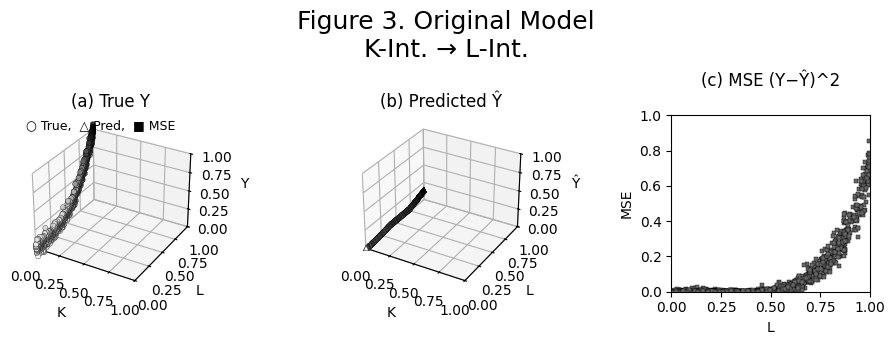

In [7]:
run_prediction(
    model, model, "Original Model",
    fig_no=1, isTL=False,
    caption=['Good fit', 'Poor fit', 'Poor fit']
)

## Transfer Learning with 1 or 2 trainable layers

In [8]:
def build_tl_model_flexible(trainable=1, seed=SEED):
    global model
    m = tf.keras.Sequential()
    N = len(model.layers) - trainable
    for i, lyr in enumerate(model.layers):
        lyr.trainable=False
        m.add(lyr if i<N else
            Dense(lyr.weights[0].shape[-1], activation=lyr.activation,
                kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed*2)
              ))

    m.compile(optimizer="adam", loss="mse")
    return m

def build_tl_y2_y3(epochs, trainable=1):
    m_y2 = build_tl_model_flexible(trainable=trainable)
    m_y2.fit(X_K, y2, epochs=epochs, batch_size=32, verbose=0)
    m_y3 = build_tl_model_flexible(trainable=trainable)
    m_y3.fit(X_L, y3, epochs=epochs, batch_size=32, verbose=0)

    for l2, l3 in zip(m_y2.layers, m_y3.layers):
        print(f"{l2.name:25s} tr={l2.trainable}   {l3.name:25s} tr={l3.trainable}")
    return m_y2, m_y3

In [9]:
ep=30

input_relu                tr=False   input_relu                tr=False
dense                     tr=False   dense                     tr=False
dense_1                   tr=False   dense_1                   tr=False
dense_4                   tr=True   dense_6                   tr=True
dense_5                   tr=True   dense_7                   tr=True


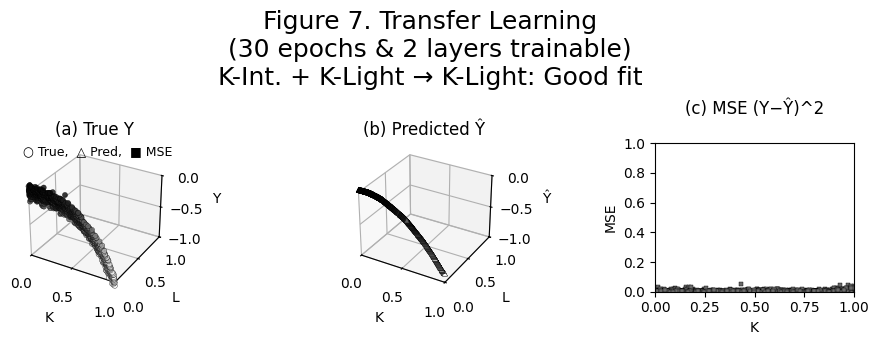

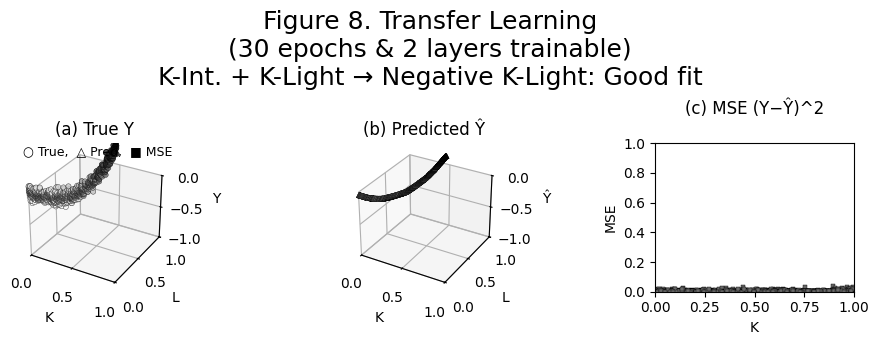

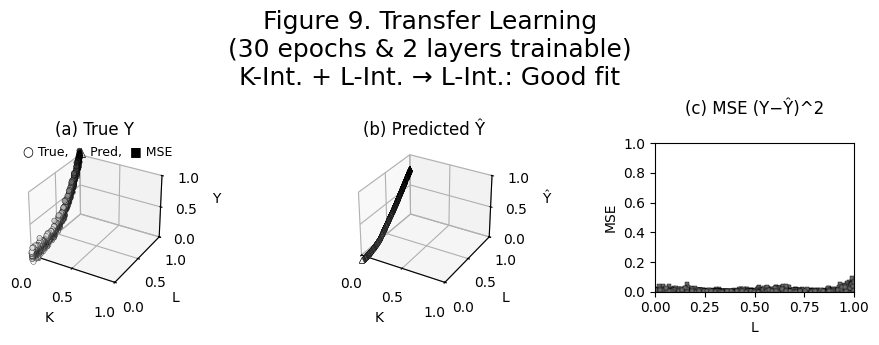

In [10]:
model_tf_2layer_y2, model_tf_2layer_y3 = build_tl_y2_y3(ep, trainable=2)

run_prediction(
    model_tf_2layer_y2, model_tf_2layer_y3,
    title=f'Transfer Learning\n({ep} epochs & 2 layers trainable)',
    fig_no=7, isTL=True, caption=['Good fit']*3
)

input_relu                tr=False   input_relu                tr=False
dense                     tr=False   dense                     tr=False
dense_1                   tr=False   dense_1                   tr=False
dense_2                   tr=False   dense_2                   tr=False
dense_8                   tr=True   dense_9                   tr=True


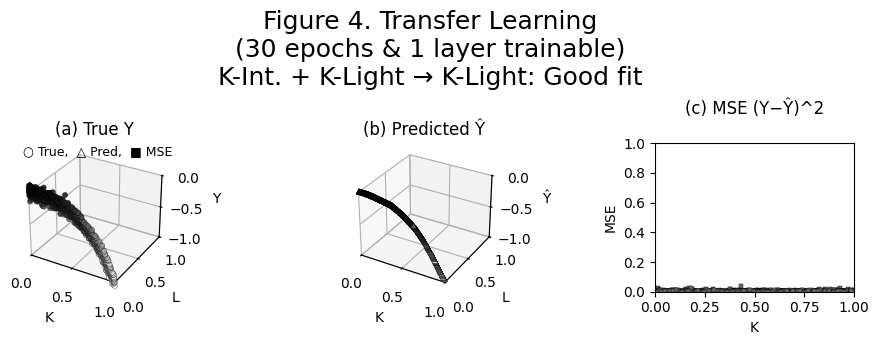

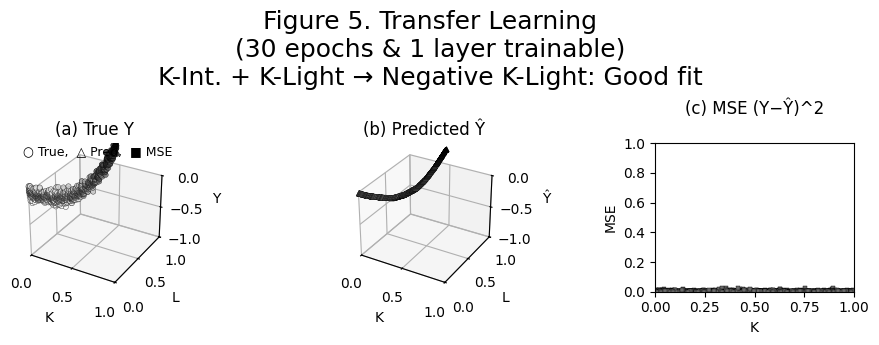

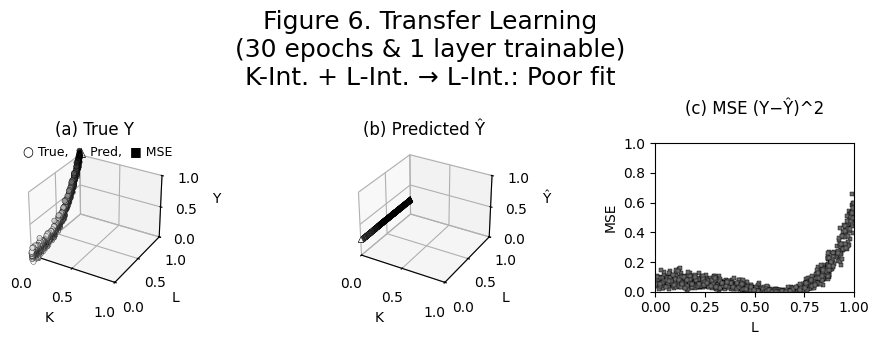

In [11]:
model_tf_1layer_y2, model_tf_1layer_y3 = build_tl_y2_y3(ep, trainable=1)

run_prediction(
    model_tf_1layer_y2, model_tf_1layer_y3,
    title=f'Transfer Learning\n({ep} epochs & 1 layer trainable)',
    fig_no=4, isTL=True, caption=['Good fit']*2 +['Poor fit']
)

# Feature Norm

### library

In [12]:
import matplotlib.style as style

style.use('tableau-colorblind10')

# --------------------------
# 1) Robust mask computation
# --------------------------
def get_relu_keep_probs_aligned(model, X_batch):
    X = tf.identity(X_batch)
    masks, layer_indices = [], []

    for idx, layer in enumerate(model.layers):
        ws = layer.get_weights()
        if len(ws) == 0:
            try: # no weights -> forward propagate to update X for subsequent layers
                X = layer(X)
            except Exception:
                # fallback: if layer defines 'activation' wrapper, apply it; else skip
                act = getattr(layer, "activation", None)
                if act is not None:
                    X = act(X)
            continue

        W_tf = tf.convert_to_tensor(ws[0], dtype=tf.float32)
        z = tf.matmul(X, W_tf) # pre-activation z = X @ W + b (if present)
        if len(ws) > 1:
            b_tf = tf.convert_to_tensor(ws[1], dtype=tf.float32)
            z = z + b_tf  # broadcast

        act = getattr(layer, "activation", None)
        masks.append(
            tf.reduce_mean(tf.cast(z > 0.0, tf.float32), axis=0).numpy()
            if (act == tf.keras.activations.relu) else None)
        layer_indices.append(idx)

        try: # propagate X using the actual layer (so next z computed correctly)
            X = layer(X)
        except Exception:
            X = act(z) if act is not None else z


    return masks, layer_indices

def compute_forward_path(
     Ws, Bs, i,
     dense_layer_indices, layer_idxs,
     masks, include_bias=False, onehot=True
):
    e = np.zeros(Ws[0].shape[0], dtype=np.float64)
    e[i] = 0

    paths = []
    for trial in range(1 if onehot else 11):
      if not onehot:
          e[1-i] = 0.1 * (trial)
      path, v = [e.copy()], None
      for k, W in enumerate(Ws):
          if v is None: # first weight-layer: contribution e @ W
              v = e @ W  # shape (out_dim,)
          else:
            # find mask position for prev_layer_idx inside dense_layer_indices
            pos = dense_layer_indices.index(layer_idxs[k-1])
            v *= masks[pos] if masks[pos].all() else 1  # element-wise
            v = v @ W # propagate to next layer

          if include_bias and Bs[k] is not None:
              v = v + Bs[k]
          path.append(v.copy())
          # print(path[-1].shape, sum(path[-1]**2)**(0.5))
      paths.append(path)
    return paths

def layer_stats(path):
  layer_L1 = [np.sum(np.abs(x)) for x in path]
  total = sum(layer_L1) if sum(layer_L1) != 0 else 1.0
  layer_pct = [x / total for x in layer_L1]
  layer_units = [x.shape[0] for x in path]
  return layer_L1, layer_pct, layer_units


# --------------------------
# 2) Feature path computation
# --------------------------
def feature_path(_model, i, X_batch, include_bias=False, onehot=True):
    masks, dense_layer_indices = get_relu_keep_probs_aligned(_model, X_batch)
    Ws, Bs, layer_idxs = [], [], []
    for idx, layer in enumerate(_model.layers):
        ws = layer.get_weights()
        if len(ws) == 0: continue;
        Ws.append(ws[0].astype(np.float64))
        Bs.append((ws[1].astype(np.float64) if (include_bias and len(ws) > 1) else None))
        layer_idxs.append(idx)

    if len(Ws) == 0:
        raise ValueError("Model has no weight-containing layers.")

    paths = compute_forward_path(
        Ws, Bs, i, dense_layer_indices,
        layer_idxs, masks, include_bias, onehot)

    # layer_L1, layer_pct, layer_units = layer_stats(path)
    return {
        "paths": paths,
        "layer_idxs": layer_idxs, "masks": masks,
        "dense_layer_indices": dense_layer_indices
    }


In [13]:
# --------------------------
# 3) Plot helper (no external fm/sp)
# --------------------------


marker = ["x", "."]
order_ = ['Input', 'Hidden 1', 'Hidden 2', 'Hidden 3', 'Output']

input_str = lambda t,f: f"(K={f[t][0][0]:.1f}, L={f[t][0][1]:.1f})"

def plot_feature_path(model, freeze_feat, X_batch, vmin=-2, vmax=2, cmap='gray', caption=''):
    # compute all feature paths
    feat_vecs = feature_path(model, freeze_feat, X_batch, onehot=False)['paths']
    rows, cols = len(feat_vecs), len(feat_vecs[0])
    layer_titles = [f"{order_[k]}\n(# = {feat_vecs[0][k].shape[0]})\n" for k in range(cols)]
    print(rows, cols)

    temp = feat_vecs[::3].copy()
    fig, axes = plt.subplots(len(temp), cols, figsize=(cols+1, len(temp)*2))
    for k in range(cols):
      axes[0][k].set_title(layer_titles[k], fontsize=12)
    for t in range(len(temp)):
      axes[t][0].set_ylabel(input_str(t, temp), fontsize=12)
      for k, v in enumerate(temp[t]):
          ax = axes[t][k]; ax.set_yticks([]); ax.set_xticks([]);
          ax.imshow(v[np.newaxis, :].T, aspect='auto', vmin=vmin, vmax=vmax, cmap=cmap)
      axes[t][-1].text(0, 0, f"{v[0]:.2f}", ha="center", va="center",
                       color='white' if v[0]<0 else 'black')

    cbar = fig.colorbar(
        plt.cm.ScalarMappable(
          norm=plt.cm.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cmap),
          ax=axes.ravel().tolist(), orientation='vertical', fraction=0.12, pad=0.02, aspect=20)
    cbar.set_label("Value")
    plt.show()

    plt.figure(figsize=(6,3))
    for t in range(rows):
      plt.plot(range(1, cols+1), [np.linalg.norm(v, 2) for v in feat_vecs[t]],
          marker=marker[t%len(marker)], label=input_str(t, feat_vecs),
          color='gray', markersize=10, linestyle=["-", "-", "--"][t%3])
    plt.xlabel("Layer Index")
    plt.ylabel("||Latent Feature||_2")
    plt.title(f"Latent Feature: L2 Norm through Each Layer\n{caption}")
    plt.xticks(range(1, cols+1))
    plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1))
    plt.grid(alpha=0.2)
    plt.ylim(0, 3)
    plt.show()

### Forward Propagation

#### Original Model

11 5


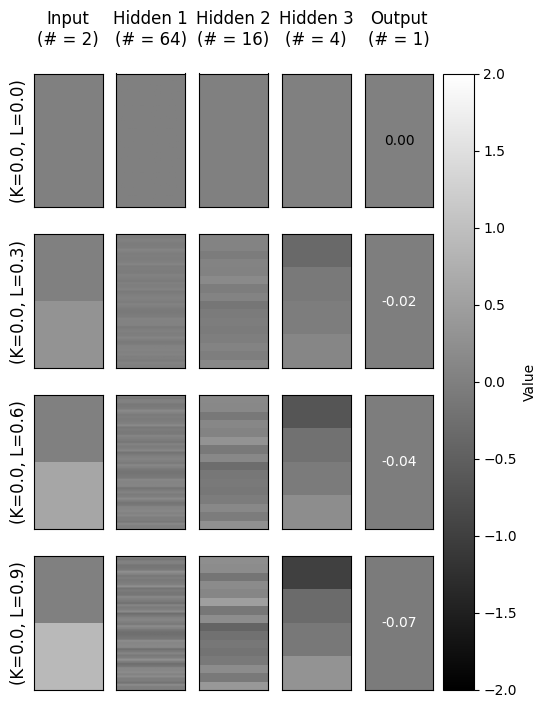

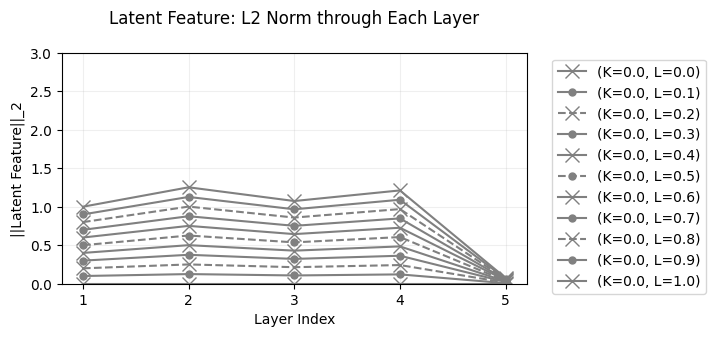

In [14]:
plot_feature_path(model, freeze_feat=0, X_batch=X_K, caption="") # Original Model(K^3) does not react to L var

11 5


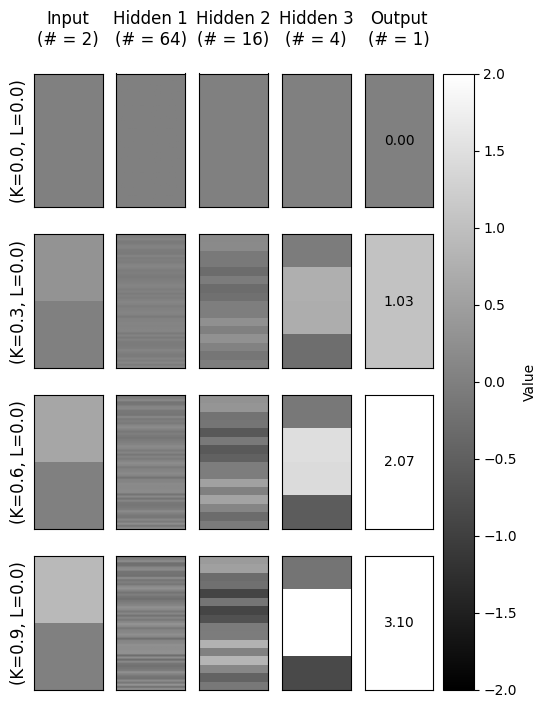

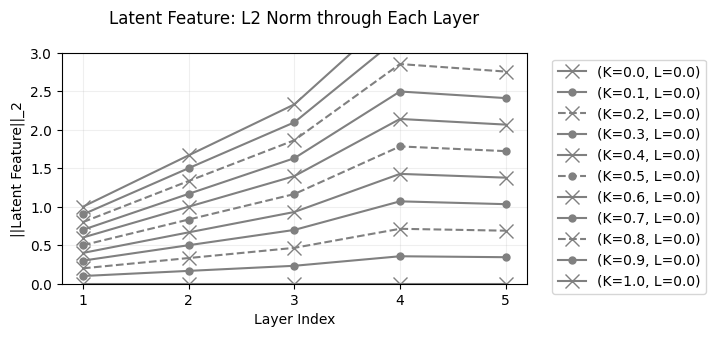

In [15]:
plot_feature_path(model, freeze_feat=1, X_batch=X_K, caption="") # Original Model(K^3) does not react to L var

#### TL on -K^3

11 5


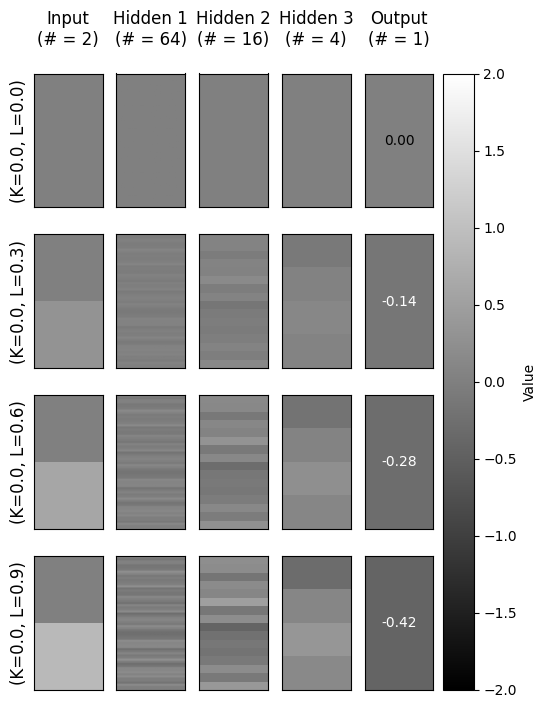

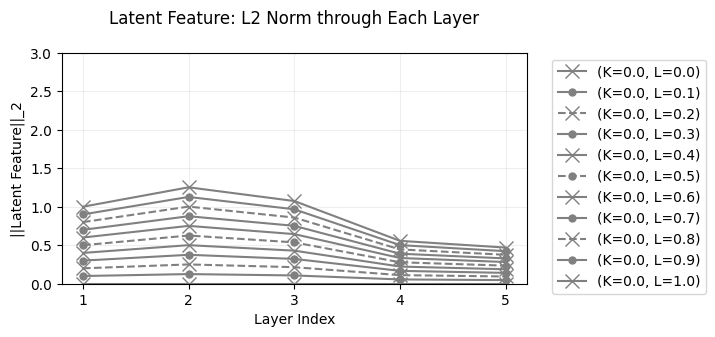

In [16]:
plot_feature_path(model_tf_2layer_y2, freeze_feat=0, X_batch=X_K)

11 5


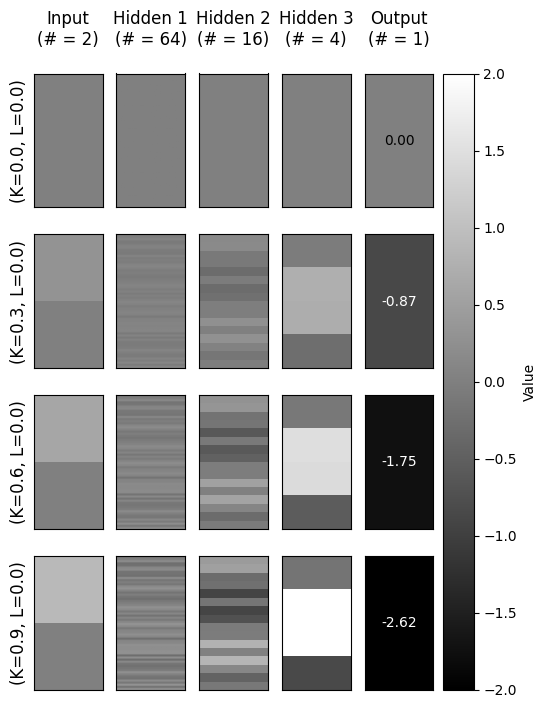

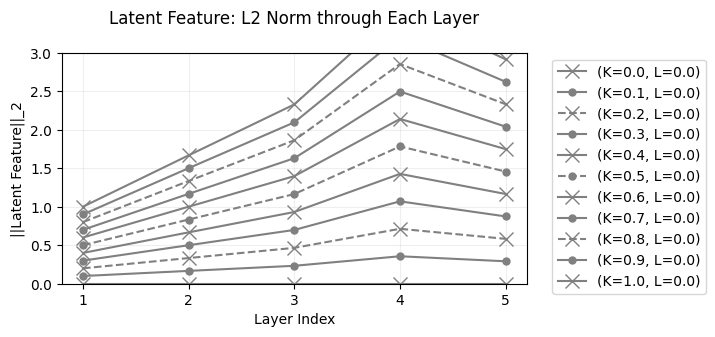

In [17]:
plot_feature_path(model_tf_1layer_y2, freeze_feat=1, X_batch=X_K)

#### TL on L^3

11 5


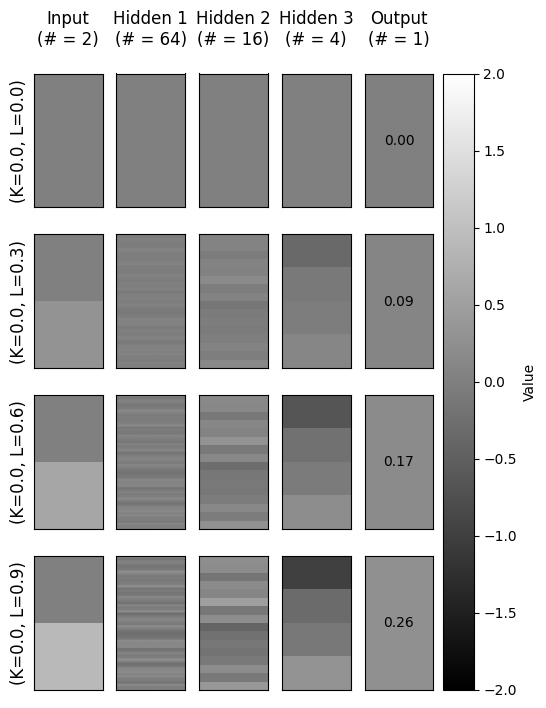

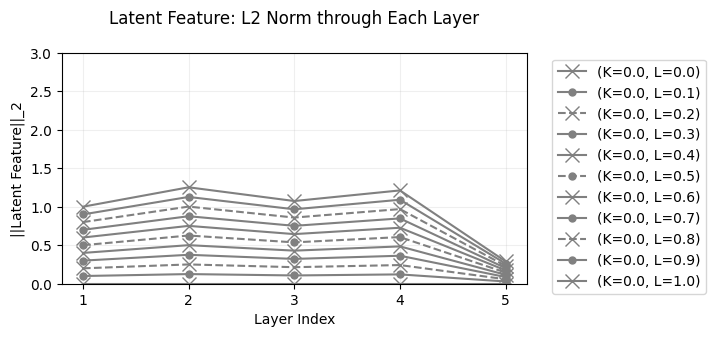

In [18]:
plot_feature_path(model_tf_1layer_y3, freeze_feat=0, X_batch=X_L)

11 5


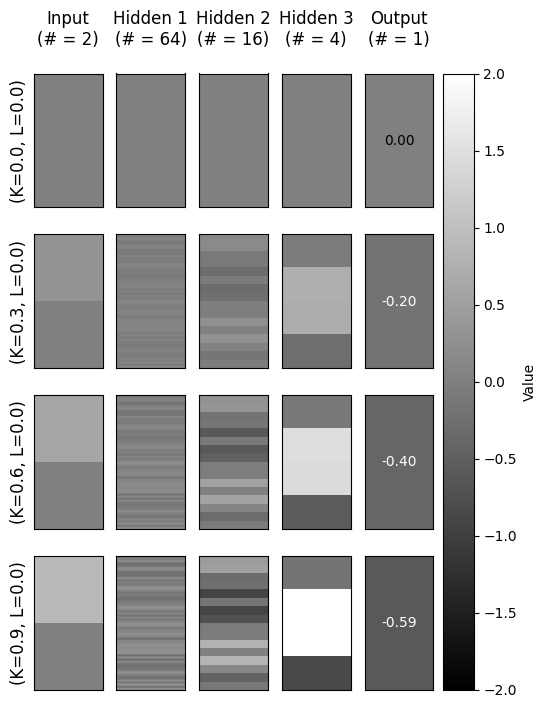

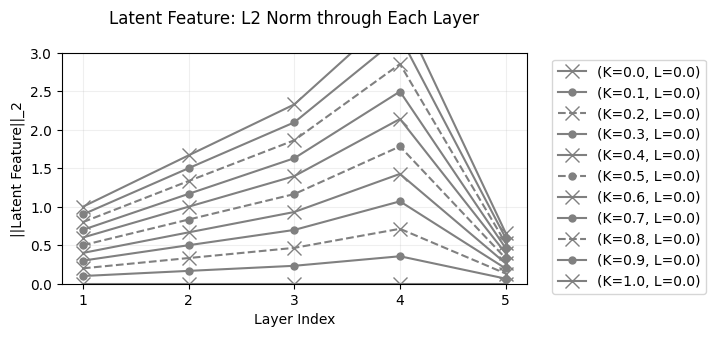

In [19]:
plot_feature_path(model_tf_1layer_y3, freeze_feat=1, X_batch=X_L)

# 10 trials for Unknown Parameter
#### Show 10 Trials and Mean (model trained on K-intensive predicting L-intensive data)

In [20]:
from sklearn.metrics import mean_squared_error
import numpy as np

n_trials = 10

L_true_1d = y3.ravel()
K0_1d = K0.ravel()
L_1d  = L.ravel()

In [21]:
# ---------- Compact Version: Base & Transfer Learning ----------

def run_trials(n_trials, train_X, train_y, eval_X, eval_y, epochs, note_label, fig_no, tl_model=None):
    preds, mses = [], []

    for t in range(n_trials):
        print(f"[Trial {t+1}/{n_trials}] training on {note_label} ...")
        m = build_model(fixed=False) if tl_model is None else tl_model()

        m.fit(train_X, train_y, epochs=epochs, batch_size=32, verbose=0)
        pred = m.predict(eval_X, verbose=0).ravel()
        preds.append(pred)

        mse_t = mean_squared_error(eval_y.ravel(), pred)
        mses.append(mse_t)
        print(f"[Trial {t+1}/{n_trials}] MSE = {mse_t:.6f}")

    preds_raw = preds.copy()
    preds = np.vstack(preds)
    pred_mean = preds.mean(axis=0)
    mse_mean = mean_squared_error(eval_y.ravel(), pred_mean)
    print(f"\nMean MSE over {n_trials} trials ({note_label}): {mse_mean:.6f}")

    draw_triptych(
        title_prefix=f"[{note_label} → {note.y3}]",
        Kv=K0_1d, Lv=L_1d, y_true=eval_y.ravel(), y_pred=pred_mean,
        fig_no=fig_no, y_lim=(-0.1, 1.1),
        caption=f" Mean of {n_trials} trials"
    )

    for t in range(n_trials):
        plt.scatter(eval_y, preds_raw[t], color="gray", alpha=0.2, s=5)
    plt.title(f"Overlay of all {n_trials} trials\n", fontdict={'fontsize': 14})
    plt.xlabel("L"); plt.ylabel("Ŷ"); plt.grid(); plt.show();


[Trial 1/10] training on K-Int. ...
[Trial 1/10] MSE = 0.345400
[Trial 2/10] training on K-Int. ...
[Trial 2/10] MSE = 0.081151
[Trial 3/10] training on K-Int. ...
[Trial 3/10] MSE = 0.155477
[Trial 4/10] training on K-Int. ...
[Trial 4/10] MSE = 0.139439
[Trial 5/10] training on K-Int. ...
[Trial 5/10] MSE = 0.086230
[Trial 6/10] training on K-Int. ...
[Trial 6/10] MSE = 0.153128
[Trial 7/10] training on K-Int. ...
[Trial 7/10] MSE = 0.131169
[Trial 8/10] training on K-Int. ...
[Trial 8/10] MSE = 0.163861
[Trial 9/10] training on K-Int. ...
[Trial 9/10] MSE = 0.098786
[Trial 10/10] training on K-Int. ...
[Trial 10/10] MSE = 0.157100

Mean MSE over 10 trials (K-Int.): 0.138401


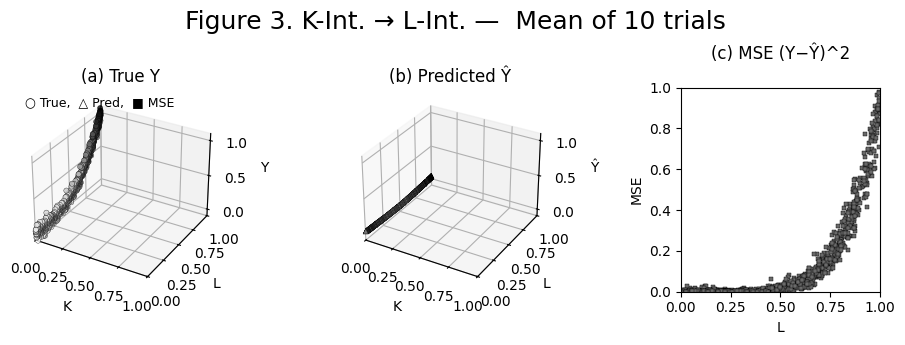

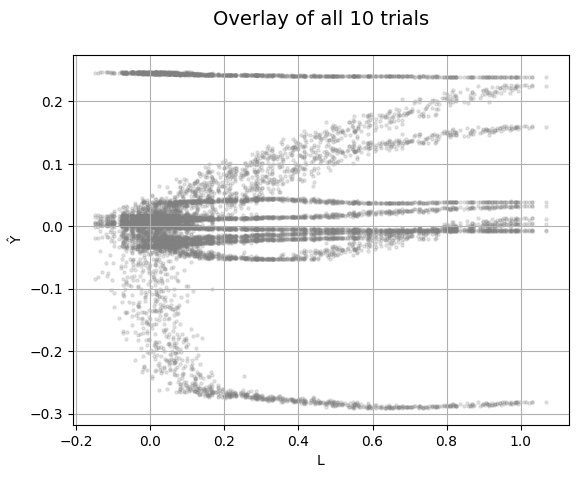

In [22]:
# ---------- (1) Base model: train y1 → test y3 ----------
run_trials(
    n_trials=n_trials,
    train_X=X_K, train_y=y1,
    eval_X=X_L, eval_y=y3,
    epochs=ep, note_label=note.y1,
    fig_no=3
)

[Trial 1/10] training on K-Int. + L-Int. ...
[Trial 1/10] MSE = 0.069485
[Trial 2/10] training on K-Int. + L-Int. ...
[Trial 2/10] MSE = 0.065024
[Trial 3/10] training on K-Int. + L-Int. ...
[Trial 3/10] MSE = 0.049236
[Trial 4/10] training on K-Int. + L-Int. ...
[Trial 4/10] MSE = 0.040159
[Trial 5/10] training on K-Int. + L-Int. ...
[Trial 5/10] MSE = 0.077492
[Trial 6/10] training on K-Int. + L-Int. ...
[Trial 6/10] MSE = 0.070429
[Trial 7/10] training on K-Int. + L-Int. ...
[Trial 7/10] MSE = 0.060913
[Trial 8/10] training on K-Int. + L-Int. ...
[Trial 8/10] MSE = 0.061186
[Trial 9/10] training on K-Int. + L-Int. ...
[Trial 9/10] MSE = 0.060085
[Trial 10/10] training on K-Int. + L-Int. ...
[Trial 10/10] MSE = 0.046936

Mean MSE over 10 trials (K-Int. + L-Int.): 0.059047


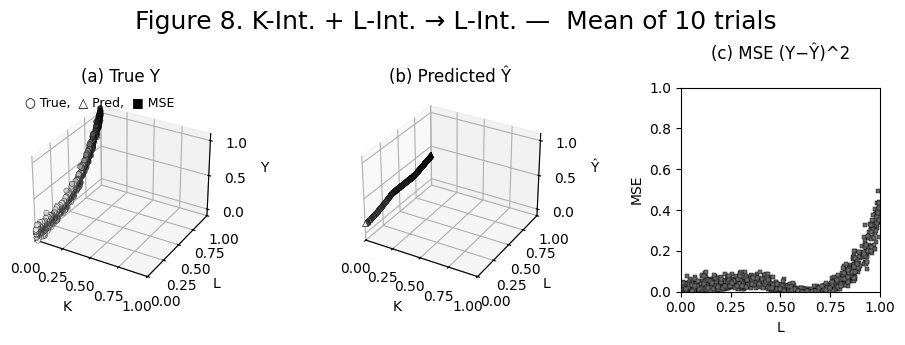

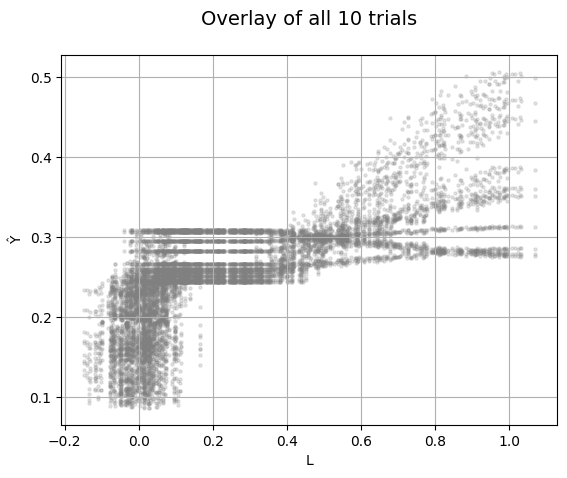

In [23]:
# ---------- (2) Transfer learning: freeze backbone + retrain head ----------
def build_tl_model():
    m_tl = Sequential(name="model_tf_1layer_y3")
    for lyr in model.layers[:-1]:
        lyr.trainable = False
        m_tl.add(lyr)
    m_tl.add(Dense(1, activation="linear", name="head_2layer_y3"))
    m_tl.compile(optimizer="adam", loss="mse")
    return m_tl

run_trials(
    n_trials=n_trials,
    train_X=X_L, train_y=y3,
    eval_X=X_L, eval_y=y3,
    epochs=ep,
    note_label=f"{note.y1} + {note.y3}",
    fig_no=8, tl_model=build_tl_model
)
